In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
con = sqlite3.connect('drive/MyDrive/amazon-fine-food/database.sqlite')

In [ ]:
filtered_data= pd.read_sql_query("""
  select * from reviews where Score!=3
""",con)

In [ ]:
def partition(x):
  if(x>3):
    return 'positive'
  else:
    return 'negative'

In [ ]:
actualscore=filtered_data['Score']
positiveNegative = actualscore.map(partition)
filtered_data['Score']=positiveNegative

In [ ]:
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True)

In [ ]:
sorted_data.shape

(525814, 10)

In [ ]:
sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=True)

In [ ]:
sorted_data.shape

(364173, 10)

In [ ]:
sorted_data=sorted_data[sorted_data.HelpfulnessNumerator<=sorted_data.HelpfulnessDenominator]

In [ ]:
sorted_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [ ]:
import re
import string
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = set(stopwords.words('english'))

In [ ]:
 from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
 count_vect = CountVectorizer()  #from scikit learn

In [ ]:
snow= nltk.stem.SnowballStemmer('english')

bag of word formation


In [ ]:
final_counts = count_vect.fit_transform(sorted_data['Text'].values)

In [ ]:
type(final_counts)

scipy.sparse._csr.csr_matrix

In [ ]:
final_counts.get_shape()

(364171, 115281)

In [ ]:
def cleanhtml(sentence):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr,' ',sentence)
  return cleantext

def clean_punctutaion(sentence):
  cleaned= re.sub(r'[?!|\'|"|#]',r' ',sentence)
  cleaned= re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
  return cleaned

In [ ]:
sorted_data['Text'].values[0]

"this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college"

In [ ]:
sorted_data['Score']

138706    positive
138688    positive
138689    positive
138690    positive
138691    positive
            ...   
178145    positive
173675    positive
204727    positive
5259      positive
302474    positive
Name: Score, Length: 364171, dtype: object

In [ ]:
i=0
all_positive_words=[]
all_negative_words=[]
final_strings=[]
s=''
for sent in sorted_data['Text']:
  filtered_sentence=[]
  sent = cleanhtml(sent)
  for w in sent.split():
    cleaned_word= clean_punctutaion(w)
    if((cleaned_word.isalpha()) & (len(cleaned_word)>2)):
      if cleaned_word.lower() not in stop:
        s= (snow.stem(cleaned_word.lower())).encode('utf8')
        filtered_sentence.append(s)
        if(sorted_data['Score'].values)[i]=='positive':
          all_positive_words.append(s)
        else:
          all_negative_words.append(s)
  str1=b" ".join(filtered_sentence)
  final_strings.append(str1)
  i+=1

In [ ]:
sorted_data['cleaned_text']=final_strings


In [ ]:
sorted_data['cleaned_text'].values

array([b'witti littl book make son laugh recit car drive along alway sing learn droop love new word book introduc silli classic book will bet son still abl recit memori colleg',
       b'grew read sendak watch realli rosi movi incorpor love son love miss hard cover paperback seem kind flimsi take two hand keep page',
       b'fun way children learn month learn poem throughout school like handmot invent',
       ..., b'bought hazelnut past local shop palm tast excel healthier',
       b'purchas product local store kid love quick easi put toaster oven toast readi strong recommend',
       b'purchas send son away deliv right dorm room fast love much call thank hard ever call want kid call good snack get midterm send'],
      dtype=object)

In [ ]:
bow_cleaned_text=count_vect.fit_transform(sorted_data['cleaned_text'].values)

In [ ]:
x_data=bow_cleaned_text
y_data=sorted_data['Score']

In [ ]:
y_data=y_data.replace(to_replace='positive',value=1)
y_data=y_data.replace(to_replace='negative',value=0)


NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train , x_test , y_train , y_test = train_test_split(x_data,y_data,test_size=0.2)
scaler= StandardScaler(with_mean=False)
x_train= scaler.fit_transform(x_train)

In [ ]:
x_train.shape

(291336, 58573)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_pred=knn.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.8436465984760074


NameError: ignored

NameError: ignored

SyntaxError: ignored

(42000, 785)

(42000,)

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

(42000, 784)

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 0, Length: 784, dtype: int64

pandas.core.series.Series

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 188, 255,  94,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 191, 250, 253,  93,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

SyntaxError: ignored

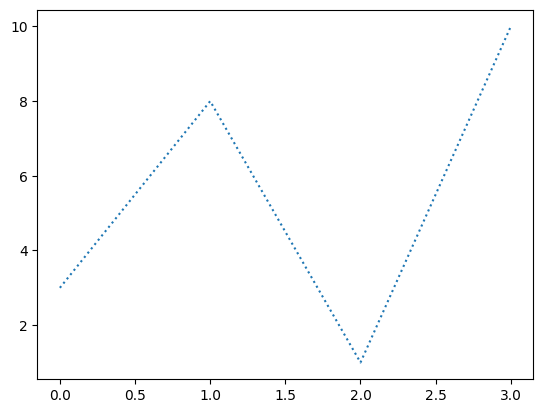

ok


AttributeError: ignored